# Gaussian Processes

Most of the math here was taken from *C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning*


<p style="text-align: center;">
**Gaussian**: Probability distribution over a continuous variable
</p>

 <p style="text-align: center;"> $\Downarrow$ </p>

<p style="text-align: center;">
**Multivariate Gaussian**: joint probability over many variables
</p>

 <p style="text-align: center;"> $\Downarrow$ </p>

<p style="text-align: center;">
**Gaussian Process**: Probability distribution over continuous functions (which we assume to be "Gaussian")
</p>

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
from scipy.linalg import cholesky
from scipy.linalg import cho_solve
from scipy.linalg import solve_triangular
from matplotlib import pyplot as plt

If we want to use GPs, we are usually in a situation that we do have some (measured) points of a function and would like to know what the function connecting them could look like. But first we need to look at a lot more points.

In [2]:
# for uniformly spaced test values
#points = np.arange(0., 1.01, 0.001)
# for randomly spaced test values
points = np.random.random_sample((1000, ))
points.sort()

We need to calculate the covariance matrix between the 1000 points $x$ we are interested in.

THe assumed covariance here is the *squared exponential kernel* 
		$$ cov \ f(\boldsymbol x_p ), f (\boldsymbol x_q ) = k(\boldsymbol x_p , \boldsymbol x_q ) = exp - \frac{1}{2} |\boldsymbol x_p - \boldsymbol x_q |^2$$

In [3]:
def squared_exp(x_p, x_q, l=1, sigma_f_squared=1):
    k = sigma_f_squared * np.exp(-0.5*((x_p-x_q)/l)**2)
    return k

In [4]:
def calculate_covariances(points, other_points=None, func=squared_exp, l=1):
    if other_points is None:
        other_points = points

    covarianceMat = np.zeros((np.shape(points)[0], np.shape(other_points)[0]))

    it = np.nditer(covarianceMat, flags=['multi_index'], op_flags=['writeonly'])
    while not it.finished:
        i = it.multi_index[0]
        j = it.multi_index[1]
        covarianceMat[i][j] = func(points[i], other_points[j], l)
        it.iternext()

    return covarianceMat

The parameter `l` tells us "how far" the influence of every point should reach. 

The covariance matrix tells us how much every point influences every other point. It is symmetric.

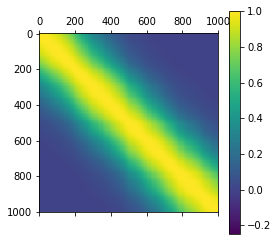

In [5]:
l=0.2
test_covariances = calculate_covariances(points, l=l)

#show the covariance matrix
plt.matshow(test_covariances)
plt.clim(-0.25,1.)
plt.colorbar()
plt.show()

Now for our measured -- or "training" -- points $x_*$

In [6]:
num_samples = 4
training_samples = np.random.random_sample([num_samples,2])
sigma_n_squared=0.01

which we also assume to be Gaussian, with standard deviation $\sigma_n$.

Gaussian (Multivariate) Distribution: 

$$\mathcal{N}(\mu, \boldsymbol\Sigma)(x) =  \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma|}} \exp\left(-\frac{1}{2}({x}-{\mu})^T{\boldsymbol\Sigma}^{-1}({x}-{\mu}) \right)$$

with $\mu, \boldsymbol\Sigma$ being the usual mean (point) and covariance (vector) for the point.

$\Rightarrow$ to predict output function $f_*$ for a test case $x_*$:
	$$p(f_*|\boldsymbol x_*, X, \boldsymbol y) = \mathcal{N}( \frac{1}{\sigma_n^2 }\boldsymbol x_*^T A^{-1} X \boldsymbol y , x_*^T A^{-1} x_*)$$
    
where $A$ is the training point covariance matrix.

In [7]:
def calculate_predictive_cov(training_samples, test_points, test_covariances, l=1, sigma_n_squared=0.01):
    training_cov = calculate_covariances(training_samples[:,0], l=l)
    training_cov += sigma_n_squared*np.eye(np.shape(training_cov)[0])
    train_test_cov = calculate_covariances(training_samples[:,0], test_points, l=l)
    test_train_cov = np.transpose(train_test_cov)
    inv_train_cov = inv(training_cov)

    mean = test_train_cov.dot(inv_train_cov).dot( np.transpose(training_samples[:,1]))
    covariances = test_covariances - test_train_cov.dot(inv_train_cov).dot(train_test_cov)

    return covariances, mean


This is how we can calculate the new covariance matrix, now that we know some of the points. We also get the expected mean over all possible functions for each point $x$.

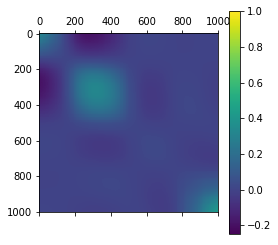

In [8]:
covariances, priormean = calculate_predictive_cov(training_samples, points, test_covariances, l=l, sigma_n_squared=sigma_n_squared)

#show the covariance matrix
plt.matshow(covariances)
plt.clim(-0.25,1.)
plt.colorbar()
plt.show()

Now we can visualize the expected distribution of functions.

In [9]:
# cf. algorithm 2.1 in RW:
def get_mean_and_variance(training_samples, test_points, k=squared_exp, l=1, sigma_n_squared=0.01):
    # compute cholesky decomposition
    num_training_samples = np.shape(training_samples)[0]
    training_cov = calculate_covariances(training_samples[:,0], l=l)
    training_cov += sigma_n_squared*np.eye(num_training_samples)
    
    #stableCov = covarianceMat[: num_training_samples, : num_training_samples] + 1e-6*np.eye(num_training_samples)
    
    L = cholesky(training_cov, lower=True)
    X = training_samples[:,0]
    y = training_samples[:,1]
    pred_mean = np.zeros(np.shape(test_points))
    variance = np.zeros(np.shape(test_points))
    alpha = cho_solve([L, True], y)

    for i in range(np.shape(test_points)[0]):
        k_test = k(test_points[i], X, l=l)
        pred_mean[i] = np.dot( k_test , alpha )
        v = solve_triangular( L, k_test, lower=True)
        variance[i] = k(test_points[i], test_points[i], l=l) - np.inner(v, v)

    return pred_mean, variance

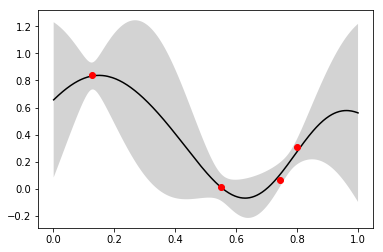

In [10]:
mean, variance = get_mean_and_variance(training_samples, points, l=l, sigma_n_squared=sigma_n_squared)
assert(max(mean - priormean) <10e-9)  # make sure we got the algebra right so far
stdev = np.sqrt(variance)
plt.fill_between(points, mean-stdev, mean+stdev, facecolor='lightgrey')
plt.plot(points, mean, 'black')

for x in training_samples:
    plt.plot(x[0],x[1],'or')
    
plt.show()

And we can randomly get example functions that correspond to this distribution.

In [11]:
def draw_values(covarianceMat, priormean=0):
    # generate u ~ N(0,eye)
    u = np.random.normal(0., 1., np.shape(covarianceMat)[0])

    # compute cholesky decomposition
    stableCov = covarianceMat + 1e-6*np.eye(np.shape(covarianceMat)[0])
    #E , V = scipy.linalg.eigh(stableCov)
    #print E
    L = cholesky(stableCov, lower=True)

    values = L.dot(u) + priormean
    return values

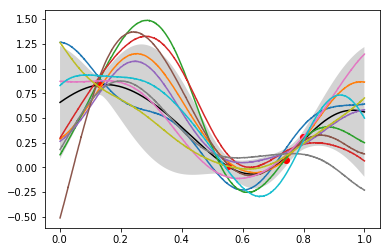

In [12]:
plt.fill_between(points, mean-stdev, mean+stdev, facecolor='lightgrey')
plt.plot(points, mean, 'black')

for x in training_samples:
    plt.plot(x[0],x[1],'or')

num_functions = 10
for i in range(num_functions):
    values = draw_values(covariances, priormean=priormean)
    plt.plot(points, values)

plt.show()

These are the functions that we generated using a Gaussian Process.

## Questions

How does the choice of $l$ and $\sigma_n$ influence the distribution and resulting possible functions?

What problem could arise if we assumed $x_*$ to be exact?

Why are there negative values in the updated covariance matrix?